# Getting started with CellRank

CellRank is a software toolkit to study dynamical biological processes, like development, regeneration, cancer or reprogramming, based on multi-view single-cell genomics data. By "multi-view", we mean that we support many different ways of estimating differentiation directionality from various input data sources, like RNA velocity, developmental potentials, pseudotemporal orderings, time course studies, metabolic labels, etc. Oftentimes, the type of downstream analysis does not depend on the modality that was used to estimate cellular transitions - that's why we modularized CellRank into **kernels**, which compute cell-cell transition matrices, and **estimators**, which analyze the transition matrices. This structure allows us to offer a consistent set of analysis capabilities, including the computation of fate probabilities, initial & terminal states, and putative driver genes, based on many input data sources. This tutorial functions as the entry point to CellRank analysis; along the way, we will point you to more specialized tutorials. 

In this tutorial, you will learn how to...

- use CellRank kernels to compute a transition matrix of cellular dynamics. 
- use CellRank estimators to analyze the transition matrix, including the computation of fate probabilities, driver genes, and gene expression trends. 
- read and write CellRank kernels.  

<img src="_static/img/cellrank_overview.png" width=800  alt="CellRank is a versatile toolking to model cellular dynamics based on multi-view single-cell data, with unified analysis capabilities. ">

**Fig** | CellRank is composed of kernels, which compute a cell-cell transition matrix, and estimators, which analyze transition matrices to reveal initial & terminal states, fate probabiliteis, driver genes, and more. 

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of human bone marrow <cite data-cite="setty:19"></cite>. 

<div class="alert alert-info">
Important
    
If you want to run this on your own data, you will need...

- a scRNA-seq dataset for which you can compute a cell-cell transition matrix using any CellRank kernel. 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/getting_started.ipynb).

## Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

In [35]:
import scanpy as sc
import cellrank as cr
import numpy as np

sc.settings.set_figure_params(facecolor='white', frameon=False, dpi=100)
cr.settings.verbosity = 2

In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Preprocess the data

Filter and normalize

In [5]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

Compute PCA and k-nearest neighbor (k-NN) graph. 

In [6]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Visualize this data, using the t-SNE embedding, cluster labels and palantir pseudotime provided with the original study <cite data-cite="setty:19"></cite>. 

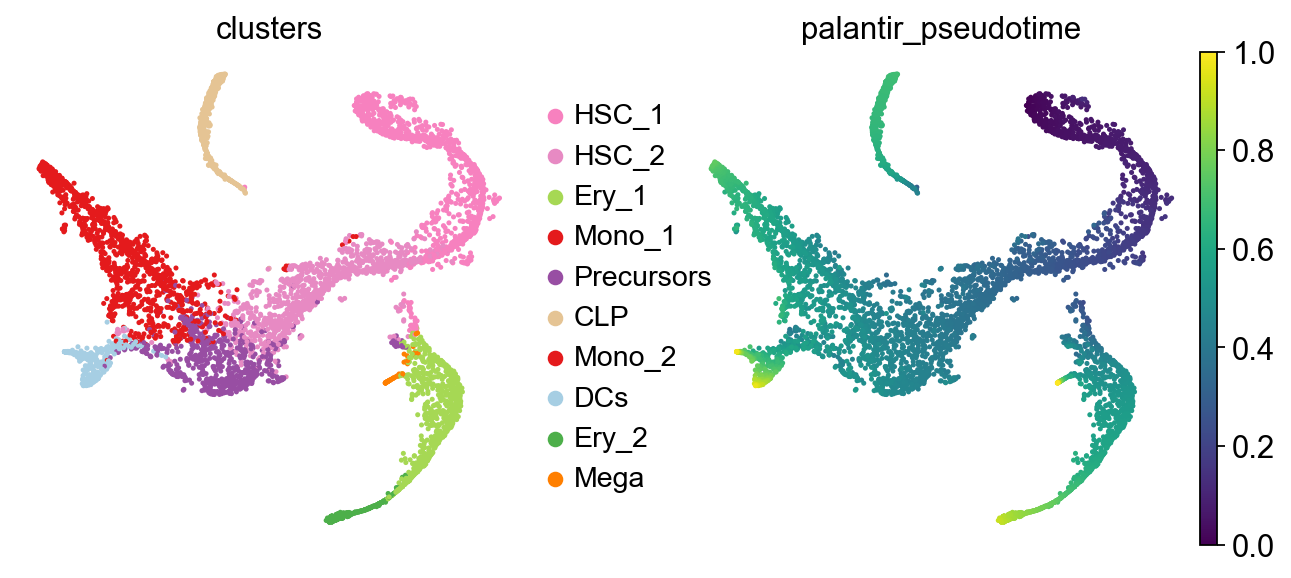

In [7]:
sc.pl.embedding(adata, basis="tsne", color=["clusters", "palantir_pseudotime"])

## Set up a kernel

To construct a transition matrix, CellRank offers a number of kernel classes in `cellrank.kernels` (REF). To demonstrate the concept, we'll use the `PseudotimeKernel`(REF) which biases k-NN graph edges to point into the direction of increasing pseudotime, inspired by [Palantir](https://github.com/dpeerlab/Palantir) (CITE). 


For a full list of kernels, check out our API (REF). To initialize a kernel object, simply run the following:

In [8]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="palantir_pseudotime")

Note that kernels need an AnnData object to read data from it - CellRank is part of the [Scanpy/AnnData ecosystem](https://scanpy.readthedocs.io/en/latest/). The only exception to this is the [PrecomputedKernel](https://cellrank.readthedocs.io/en/stable/classes.html#precomputed-kernel) which directly accepts a transition matrix, thus making it possible to interface to CellRank from outside the scanpy/AnnData world. 

To learn more about our kernel object, we can print it. 

In [9]:
pk

PseudotimeKernel[n=5780]

There isn't very much here yet! Let's use this kernel to compute a cell-cell transition matrix. 

In [10]:
pk.compute_transition_matrix()

Computing transition matrix based on pseudotime`


  0%|          | 0/5780 [00:00<?, ?cell/s]

    Finish (0:00:01)


PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

If we print the kernel again, we can inspect the parameters that were used to compute this transition matrix. 

In [11]:
pk

PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

To get a first impression of the cellular dynamics in this dataset, we can simulate random walks on the [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) implied by the transition matrix, starting from hematopoietic stem cells (HSCs), and visualize these in the t-SNE embedding. 

Simulating `100` random walks of maximum length `1445`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:12)
Plotting random walks


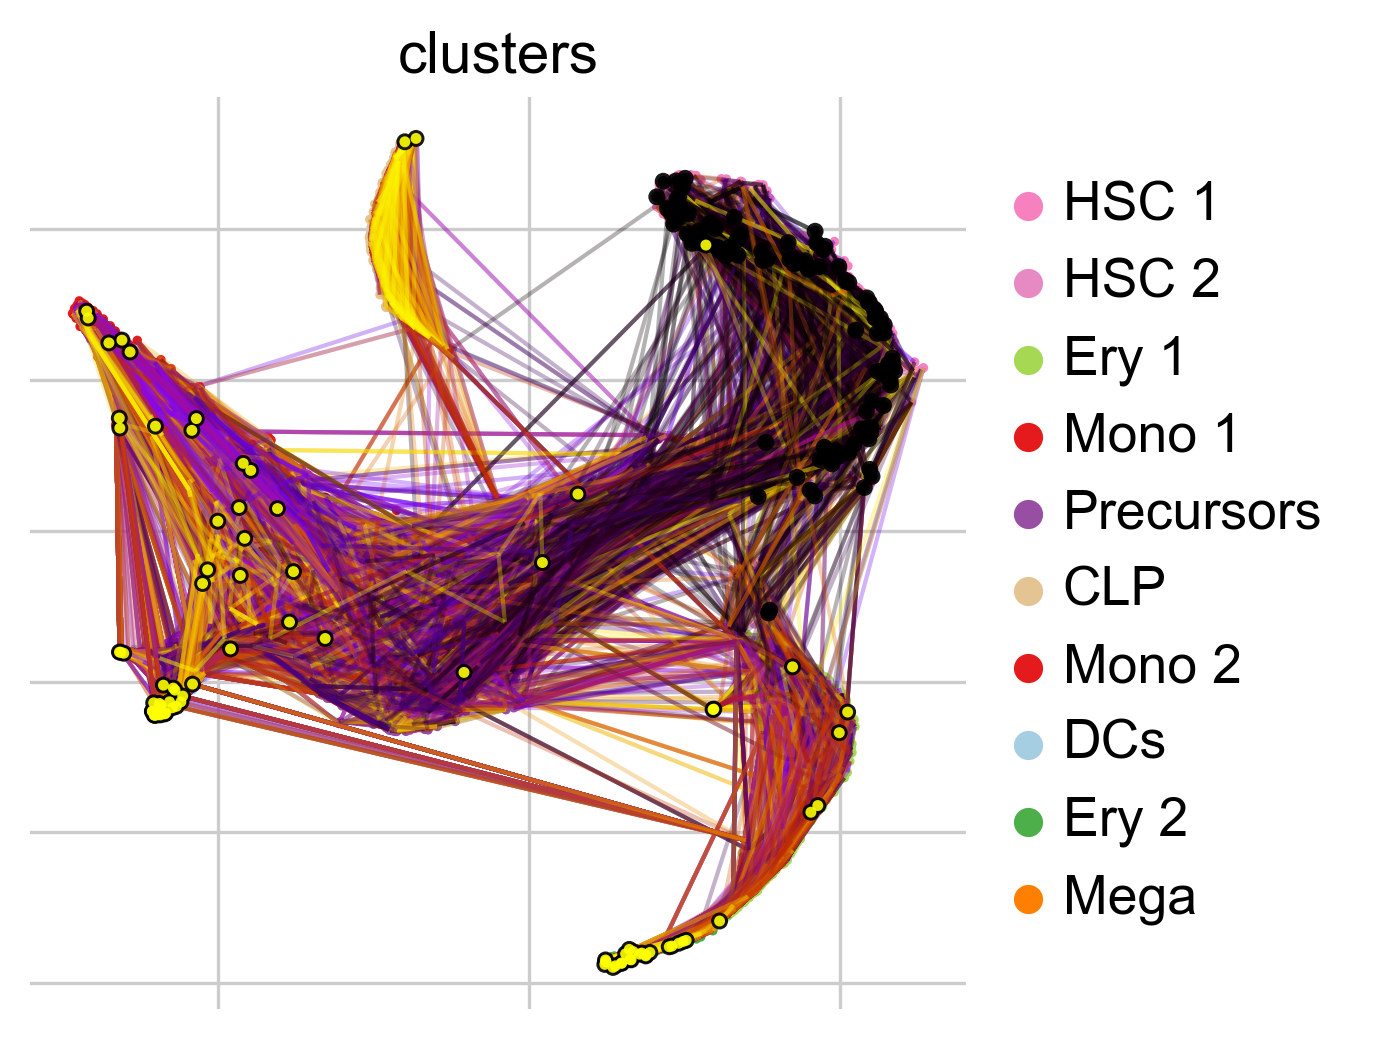

In [12]:
pk.plot_random_walks(seed=0, n_sims=100, start_ixs={"clusters": "HSC_1"}, basis="tsne", legend_loc="right", dpi=150)

Black and yellow dots indicate random walk start and terminal cells, respectively. Overall, this reflects the known differentiation hierachy in human hematopoiesis. 

<div class="alert alert-info">
Important
    
To learn more about the pseudotime kernel, see the dedicated tutorial (REF). 

</div>

## Kernel overview

There exist CellRank kernels for many different data modalities. Each modality and biological system comes with its own strenghts and limitations, so it's important to choose the kernel carefully. We provide some guidance in the figure below. However, please check the API (REF) for a complete and up-to-date list, as new kernels will come. 



<img src="_static/img/cellrank_kernels.jpg" width=800  alt="CellRank kernels are applicable to many different data modalities. ">

If you already have a cell-cell transition matrix for your data, you can pass that directly using the PrecomputedKernel (REF), CellRank's interface with external methods. 

## Combining different kernels

Any two kernels can be globally combined via a weighted mean. To demonstrate this, let's set up an additional ConnectivityKernel (REF), based on gene expression similarity. 

In [21]:
from cellrank.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Print the kernel to see some properties

In [22]:
ck

ConnectivityKernel[n=5780, dnorm=True, key='connectivities']

Combine with the PseudotimeKernel from above. 

In [23]:
combined_kernel = 0.8*pk + 0.2*ck
combined_kernel

(0.8 * PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * ConnectivityKernel[n=5780, dnorm=True, key='connectivities'])

This works for any combination of kernels, and generalizes to more than two kernels. Kernel combinations allow you to use distinct sources of information to describe cellular dynamics. 

## Writing and reading a kernel

Sometimes, we might want to write the kernel to disk, to either continue with the analysis later on, or to pass it to someone else. This can be easily done; simpley write the kernel to adata, and write adata to file: 

In [24]:
pk.write_to_adata()
adata.write("hematopoiesis.h5ad")

To continue with the analysis, we read the AnnData object from disk, and initialize a new kernel from the AnnData object. 

In [25]:
adata = sc.read("hematopoiesis.h5ad")
pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
pk_new

PseudotimeKernel[n=5780, dnorm=False, frac_to_keep=0.3, scheme='hard']

## Creating a new kernel - contributing to CellRank

If you have you own method in mind for computing a cell-cell transition matrix, potentially based on some fancy new data modality, consider including it as a kernel in CellRank. That way, you benefit from CellRank's established interfaces with packages like [scanpy](https://scanpy.readthedocs.io/en/stable/) or [AnnData](https://anndata.readthedocs.io/en/latest/), can take advantage of existing downstream analysis capabilities, and immediatly reach a large audience of existing CellRank users. 

<div class="alert alert-info">
Important
    
To learn more about creating your own kernel, see the dedicated tutorial (REF). 

</div>

## Set up an estimator

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that represent the slow-time scale dynamics of the process. A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in `cellrank.estimators`:

 - `CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - `GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, <cite data-cite="reuter:18, reuter:19"></cite>. 
 
We recommend the GPCCA estimator; let's start by initializing it. 

In [33]:
from cellrank.estimators import GPCCA

g = GPCCA(pk)
print(g)

GPCCA[kernel=PseudotimeKernel[n=5780], initial_states=None, terminal_states=None]


## Identify initial & terminal states

Fit the estimator to compute macrostates of cellular dynamics; these may include initial, terminal and intermediate states. 

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `10` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:10)


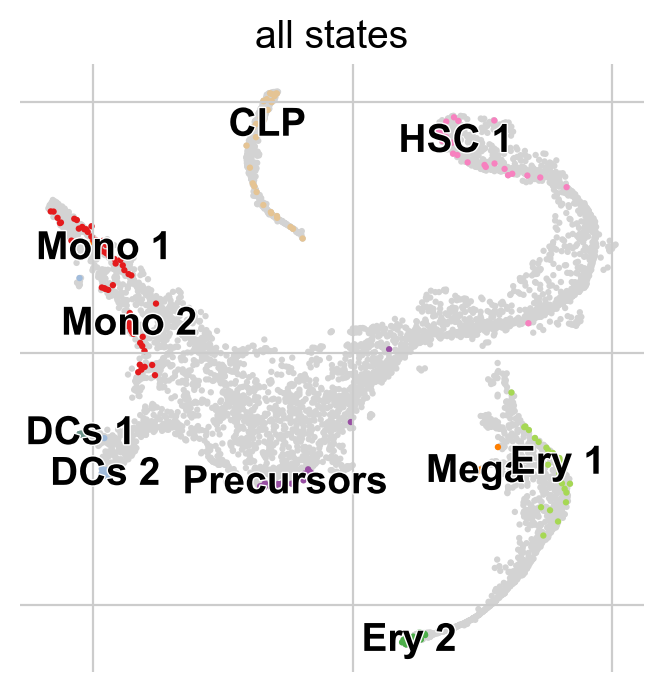

In [36]:
g.fit(n_states=10, cluster_key="clusters")
g.plot_macrostates(which="all")

For each macrostate, the algorithm computes an associated stability value. Let's use the most stable macrostates as terminal states (CITE). 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


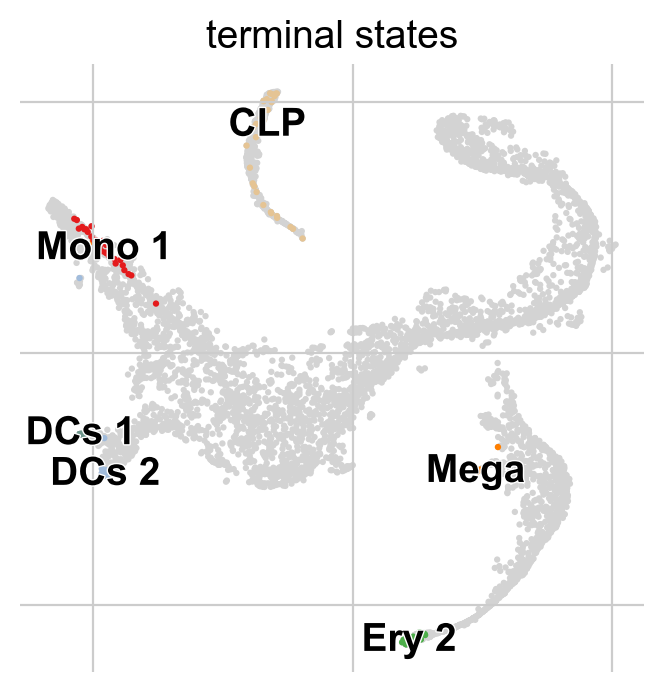

In [42]:
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal")

This correctly identified all major terminal states in this dataset. CellRank can also identify initial states - in this dataset, that does not make too much sense though, as the initial state was manually passed to Palantir to root the pseudotime computation. 

<div class="alert alert-info">
Important
    
To learn more about initial and terminal state identification, see the dedicated tutorial (REF). 

</div>

## Compute fate probabilities and driver genes

We can now compute how likely each cell is to reach each terminal state. 

Computing fate probabilities


  0%|          | 0/6 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


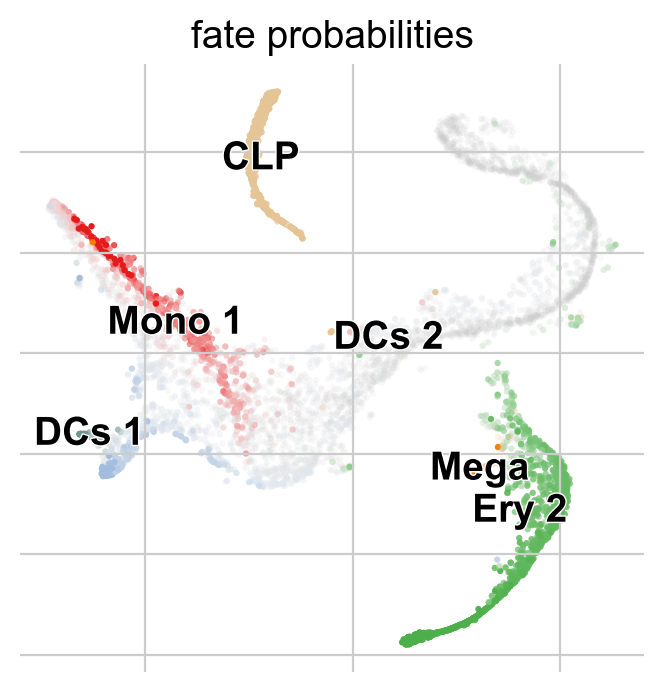

In [53]:
g.compute_fate_probabilities()
g.plot_fate_probabilities()

The plot above combines fate probabilities towards all terminal states, each cell is colored according to its most likely fate; color intensity reflects the degree of lineage priming. We could equally plot fate probabilities separately for each terminal state, or we can visualise them jointly in a circular projection. 

In [52]:
cr.pl.circular_projection(adata, keys=["clusters"])

KeyError: "Unable to find lineage data in `adata.obsm['lineages_fwd']`."

## Visualize expression trends

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using any precomputed pseudotime and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...

- going through the [initial & terminal states tutorial](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) to learn how to use the transition matrix to automatically identify initial and terminal states. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- exploring the vast amount of pseudotime methods to find the one that works best for your data <cite data-cite="saelens:19"></cite>. 

<div class="alert alert-info">
Important

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 
    
</div>

## Package versions

In [18]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
